In [6]:
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *

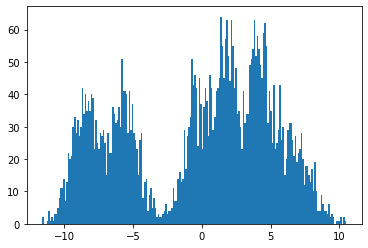

In [7]:
target = Dimension1()
data = target.sample(5000)
fig = plt.hist(data.numpy(), bins = 200)
plt.show()

In [14]:
def grads_to_vector(parameters):
    r"""Convert parameters to one vector

    Args:
        parameters (Iterable[Tensor]): an iterator of Tensors that are the
            parameters of a model.

    Returns:
        The parameters represented by a single vector
    """
    vec = []
    for param in parameters:
        vec.append(param.grad.view(-1))
    return torch.cat(vec)

def parameters_to_vector(parameters):
    r"""Convert parameters to one vector

    Args:
        parameters (Iterable[Tensor]): an iterator of Tensors that are the
            parameters of a model.

    Returns:
        The parameters represented by a single vector
    """
    vec = []
    for param in parameters:
        vec.append(param.grad.view(-1))
    return torch.cat(vec)

In [15]:
from models_dif import DIFDensityEstimator, SoftmaxWeight
from models import NDRE
architecture = DIFDensityEstimator
structure = 50
from prettytable import PrettyTable

from functools import lru_cache
import time

@lru_cache(maxsize = None)
def count_parameters(structure):
    model = architecture(data, structure)
    model.w = SoftmaxWeight(structure,1, [32,32])
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters(structure)
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     32     |
|  w.f.0.bias  |     32     |
| w.f.2.weight |    1024    |
|  w.f.2.bias  |     32     |
| w.f.4.weight |    1600    |
|  w.f.4.bias  |     50     |
|     T.m      |     50     |
|   T.log_s    |     50     |
+--------------+------------+
Total Trainable Params: 2870
2870


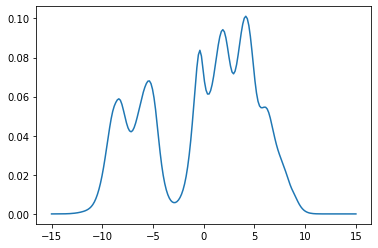

In [ ]:
from IPython.display import clear_output
import copy
from tqdm import tqdm
linspace = torch.linspace(-15.,15., 200)

#initialize model and gradients
model = architecture(data, structure)
model.w = SoftmaxWeight(structure,1, [32,32])

sigma_phi = 1
log_prior = lambda parameters: torch.distributions.MultivariateNormal(torch.zeros(parameters.shape[0]), (sigma_phi**2)*torch.eye(parameters.shape[0])).log_prob(parameters)

current_model = model
current_parameters_as_vector = torch.nn.utils.parameters_to_vector(current_model.parameters())

log_prob = -current_model.loss(data)*data.shape[0] + log_prior(current_parameters_as_vector)
log_prob.backward()
current_grad_as_vector = grad_to_vector(current_model.parameters())

tau = 1e-5
#MALA steps
for i in tqdm(range(20000)):
    if i%1==0:
        clear_output(wait = True)
        plt.figure()
        sum_density = torch.exp(current_model.log_density(linspace.unsqueeze(-1)))
        plt.plot(linspace, sum_density.detach().numpy())
        plt.show()

    #copy model
    copy_model = copy.deepcopy(current_model)
    copy_parameters_as_vector = torch.nn.utils.parameters_to_vector(copy_model.parameters())
    
    #Update parameters with langevein dynamics with current gradient values
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2)) 
            
    #compute new_log_prob

    copy_log_prior = torch.distributions.MultivariateNormal(torch.zeros(copy_parameters_as_vector.shape[0]), (sigma_phi**2)*torch.eye(copy_parameters_as_vector.shape[0])).log_prob(copy_parameters_as_vector)
    copy_log_prob = -copy_model.loss(data)*data.shape[0] + copy_log_prior
    
    #compute new gradients
    copy_model.zero_grad()
    copy_log_prob.backward()
    print(grad_to_vector(copy_model.parameters()).shape)
    
    #compute acceptance probability
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        
    #print(torch.exp(acceptance_log_prob))
    if torch.rand(1)<torch.exp(acceptance_log_prob.detach()):
        #print('accepted')
        current_model = copy_model
        log_prob = copy_log_prob